In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
!nvidia-smi

Thu Oct 31 08:22:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from fastai.vision import *

In [0]:
 ! {sys.executable} -m pip install kaggle --upgrade

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pwd

/content


In [0]:
mkdir -p ~/.kaggle/

In [0]:
! mv  ./kaggle.json ~/.kaggle/

In [0]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
p = Path('/content')
path = p/'drive'/'My Drive'/'Colab Notebooks'/'planet'
path.mkdir(parents=True, exist_ok=True)
path

NameError: ignored

In [0]:
path.as_posix()/

'/root/.fastai/data/planet'

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p '{path}'  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p '{path}'
! unzip -q -n '{path}/train_v2.csv.zip' -d '{path}'

 99% 594M/600M [00:08<00:00, 88.7MB/s]
100% 600M/600M [00:08<00:00, 72.8MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 47.9MB/s]


In [0]:
! 7za -bd -y -so x '{path}/train-jpg.tar.7z' | tar xf - -C '{path.as_posix()}'

In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [0]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
src = (ImageList.from_csv(path,'train_v2.csv', folder='train-jpg',suffix='.jpg')
        .split_by_rand_pct(0.2)
        .label_from_df(label_delim=' '))

In [0]:
data = src.transform(tfms, size=128).databunch().normalize()

In [0]:
! ls /root/.fastai/data/planet/train-jpg

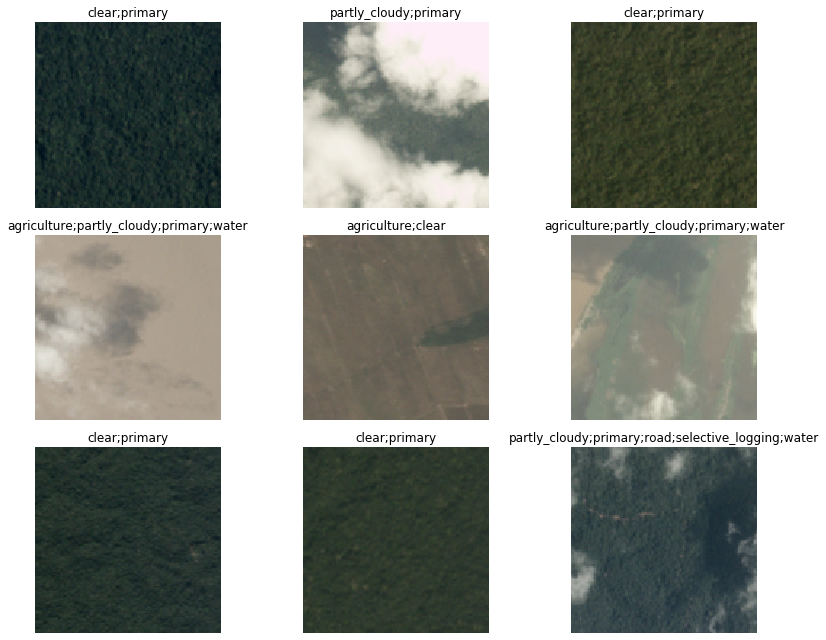

In [0]:
data.show_batch(rows=3, figsize=(12,9))


In [0]:
arch = models.resnet50
acc_02 = partial(accuracy_thresh, thresh=0.2)
acc_03 = partial(accuracy_thresh, thresh=0.3)
acc_04 = partial(accuracy_thresh, thresh=0.4)
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02,acc_03,acc_04,acc_05, f_score])

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


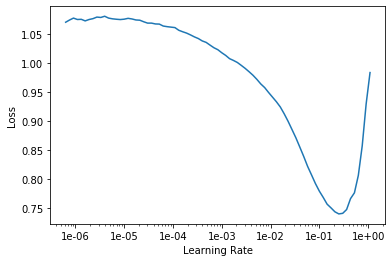

In [0]:
learn.recorder.plot()

In [0]:
lr = 3e-2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.128428,0.111478,0.943618,0.951553,0.955579,0.957359,0.906179,03:31
1,0.119013,0.103783,0.948879,0.956298,0.960339,0.962337,0.910532,03:33
2,0.110834,0.100881,0.956851,0.961734,0.963369,0.963347,0.911740,03:32
3,0.096523,0.088181,0.957047,0.963805,0.965803,0.966174,0.925682,03:34
4,0.090765,0.087111,0.957679,0.964452,0.966421,0.966712,0.925726,03:34


In [0]:
learn.save('stage-1-rn50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


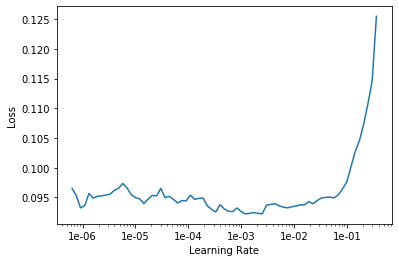

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


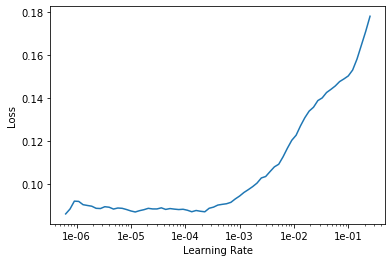

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/10))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.094328,0.093363,0.953014,0.960862,0.963856,0.964684,0.920652,04:32
1,0.098787,0.094267,0.948007,0.956880,0.961305,0.963274,0.920139,04:32
2,0.092909,0.087039,0.954925,0.962577,0.966006,0.966871,0.925288,04:31
3,0.084676,0.084236,0.957657,0.964270,0.967445,0.967481,0.928521,04:32
4,0.085141,0.083903,0.958689,0.965294,0.967692,0.968092,0.929840,04:32


In [0]:
learn.save('stage-2-rn50')

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


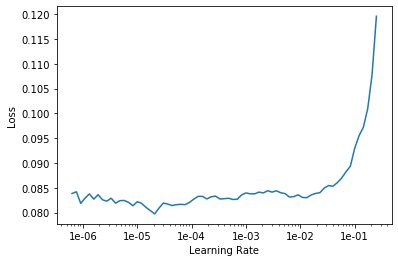

In [0]:
learn.lr_find()
learn.recorder.plot()


In [0]:
lr=1e-2/3
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.083783,0.083448,0.957352,0.964386,0.966959,0.967634,0.928680,03:31
1,0.084732,0.089898,0.958245,0.964103,0.966428,0.967286,0.928225,03:32
2,0.085713,0.085830,0.957025,0.964575,0.967387,0.967954,0.929288,03:33
3,0.078774,0.087463,0.958674,0.965047,0.967213,0.967925,0.928458,03:33
4,0.080087,0.084729,0.959358,0.965730,0.967852,0.968237,0.929213,03:34


In [0]:
learn.save('stage-1-256-rn50')


In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))


epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.075399,0.087343,0.959474,0.965215,0.967395,0.967918,0.925920,04:31
1,0.080895,0.087341,0.957679,0.963965,0.966377,0.967373,0.927095,04:31
2,0.078083,0.134063,0.959270,0.965120,0.967249,0.967329,0.928043,04:32
3,0.076341,0.084858,0.958973,0.964909,0.967460,0.967903,0.929379,04:31
4,0.073636,0.085080,0.958958,0.964735,0.967344,0.967990,0.929377,04:31


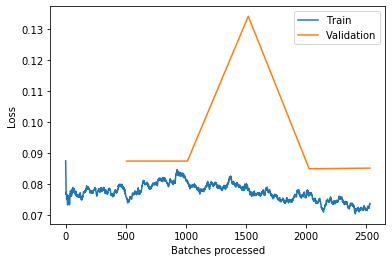

In [0]:
learn.recorder.plot_losses()


In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


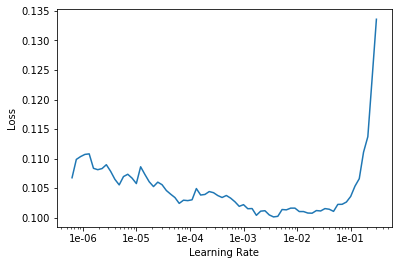

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score_02 = partial(fbeta, thresh=0.2)
acc_04 = partial(accuracy_thresh, thresh=0.4)
f_score_04 = partial(fbeta, thresh=0.4)

learn.metrics=[acc_02, f_score_02, acc_04, f_score_04]

In [0]:
lr = 1e-2/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,accuracy_thresh,fbeta,time
0,0.089724,0.086675,0.955361,0.924851,0.965992,0.910885,10:55
1,0.087691,0.126885,0.954366,0.926936,0.965469,0.916697,10:51
2,0.082934,0.093796,0.957287,0.928753,0.967024,0.916451,10:52
3,0.079754,0.084698,0.958311,0.927552,0.967264,0.915949,10:52
4,0.077592,0.090968,0.958449,0.928867,0.967416,0.916695,10:53


In [0]:
learn.unfreeze()


In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,accuracy_thresh,fbeta,time
0,0.083509,0.087675,0.957221,0.927417,0.967234,0.915098,14:13
1,0.084708,0.091528,0.957432,0.926952,0.966559,0.914166,14:08
2,0.082526,0.085075,0.959125,0.929474,0.967722,0.916345,14:25
3,0.075976,0.082633,0.959692,0.929926,0.967881,0.916637,14:18
4,0.077448,0.092175,0.960542,0.931011,0.968361,0.917229,14:18


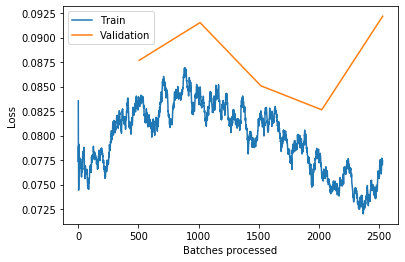

In [0]:
learn.recorder.plot_losses()


In [0]:
learn.save('stage-2-256-rn50')


In [0]:
learn.export()


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BCEWithLogitsLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/l

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  


In [0]:
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [0]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
labelled_preds[:5]

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]


In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
df.to_csv(path/'submission.csv', index=False)

In [0]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "Submission 1"

100% 2.18M/2.18M [00:03<00:00, 658kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space